# 机器学习纳米学位毕业项目 -- 猫狗大战

苗沛

2018.08.15

**实验环境**

- MacBook 10.13.6
- python 3.5.4
- numpy 1.13.0
- tensorflow 1.3.0
- Keras 1.2.2
- h5py 2.7.1

## 数据预处理

从 [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 下载训练数据到`image目录` 并解压到当前目录。

数据集的文件名是以type.num.jpg方式命名的，比如cat.0.jpg。使用 Keras 的 ImageDataGenerator 需要将不同种类的图片分在不同的文件夹中。对数据集进行预处理参考的是[杨培文的Blog](http://www.zhiding.cn/techwalker/documents/J9UpWRDfVYHE5WsOEHbyx4eM8fBcpHYEW_b72QCUihQ)创建符号链接(symbol link)的方法，这样的好处是不用复制一遍图片，占用不必要的空间。

In [4]:
import os
import shutil

os.chdir("{}/image".format(os.getcwd())) 

train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('img_train')
os.mkdir('img_train/cat')
os.mkdir('img_train/dog')

rmrf_mkdir('img_test')
os.symlink('../test/', 'img_test/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'img_train/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'img_train/dog/'+filename)

图像文件分类后的路径如下：

``` python 
├── test [12500 images]
├── test2
│   └── test -> ../test/
├── train [25000 images]
└── train2
    ├── cat [12500 images]
    └── dog [12500 images]

``` 

可视化数据集：

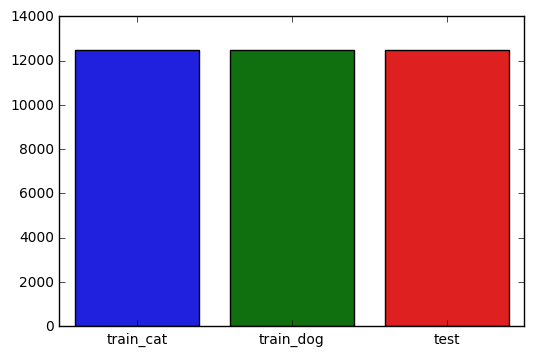

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

x = ['train_cat', 'train_dog', 'test']
y = [len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')), len(os.listdir('test'))]
ax = sns.barplot(x=x, y=y)

In [3]:
s_count = """image数据集中，猫的数量：{}，狗的数量：{}，测试集图片数量：{}""".format(len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')),len(os.listdir('test')))
s_count

'image数据集中，猫的数量：12500，狗的数量：12500，测试集图片数量：12500'

## 导出特征向量

对于这个题目来说，使用预训练的网络是最好不过的了，经过前期的测试，我们测试了 ResNet50 等不同的网络，但是排名都不高，现在看来只有一两百名的样子，所以我们需要提高我们的模型表现。那么一种有效的方法是综合各个不同的模型，从而得到不错的效果，兼听则明。如果是直接在一个巨大的网络后面加我们的全连接，那么训练10代就需要跑十次巨大的网络，而且我们的卷积层都是不可训练的，那么这个计算就是浪费的。所以我们可以将多个不同的网络输出的特征向量先保存下来，以便后续的训练，这样做的好处是我们一旦保存了特征向量，即使是在普通笔记本上也能轻松训练。

经典的CNN输入图像的尺寸，是224×224、227×227、256×256和299×299，但也可以是其他尺寸。

VGG16，VGG19和ResNet均接受224×224输入图像，而Inception V3和Xception需要299×299像素输入

In [5]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("img_train", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("img_test", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)

    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [5]:
#write_gap(ResNet50, (224, 224))

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
#write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [6]:
#write_gap(Xception, (299, 299), xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## 载入特征向量

经过上面的代码以后，我们获得了三个特征向量文件，分别是：

- gap_ResNet50.h5
- gap_InceptionV3.h5
- gap_Xception.h5

这里需要载入这些特征向量，并且将它们合成一条特征向量，然后记得把 X 和 y 打乱，不然之后设置validation_split的时候会出问题。这里设置了 numpy 的随机数种子为2018。

In [7]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

## 构建模型

模型的构建很简单，直接 dropout 然后分类就好了。

In [8]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

对模型进行可视化：

进入model_graphviz目录执行make，生成model.png

<img src="../source/model.png"/>

## 训练模型

模型构件好了以后，我们就可以进行训练了，这里我们设置验证集大小为 20% ，也就是说训练集是20000张图，验证集是5000张图。

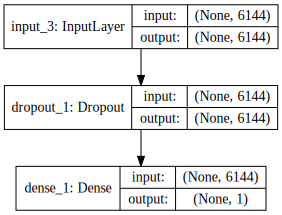

In [23]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot, plot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [24]:
hist = model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 3s - loss: 0.1209 - acc: 0.9588 - val_loss: 0.0335 - val_acc: 0.9912
Epoch 2/8
20000/20000 [==============================] - 1s - loss: 0.0299 - acc: 0.9906 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 3/8
20000/20000 [==============================] - 1s - loss: 0.0226 - acc: 0.9928 - val_loss: 0.0228 - val_acc: 0.9930
Epoch 4/8
20000/20000 [==============================] - 2s - loss: 0.0194 - acc: 0.9935 - val_loss: 0.0207 - val_acc: 0.9932
Epoch 5/8
20000/20000 [==============================] - 1s - loss: 0.0177 - acc: 0.9940 - val_loss: 0.0204 - val_acc: 0.9940
Epoch 6/8
20000/20000 [==============================] - 2s - loss: 0.0167 - acc: 0.9944 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 7/8
20000/20000 [==============================] - 2s - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0198 - val_acc: 0.9938
Epoch 8/8
20000/20000 [==============================] - 2s - loss: 0

In [25]:
model.save('model.h5')

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
# 画图
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

# 训练的acc_loss图
plot_training(hist)

NameError: name 'hist' is not defined

## 预测测试集

模型训练好以后，我们就可以对测试集进行预测，然后提交到 kaggle 上看看最终成绩了。

In [26]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

11968/12500 [===========================>..] - ETA: 0s

In [28]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("img_test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/Users/miclaelmiao/anaconda2/envs/cat_vs_dog/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


预测这里我们用到了一个小技巧，我们将每个预测值限制到了 [0.005, 0.995] 个区间内，这个原因很简单，kaggle 官方的评估标准是 LogLoss，对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大，是 15 和 2 的差别。参考 LogLoss 如何处理无穷大问题，下面的表达式就是二分类问题的 LogLoss 定义。

$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$

还有一个值得一提的地方就是测试集的文件名不是按 1, 2, 3 这样排的，而是按下面的顺序排列的：

In [22]:
%ls test | head -n 10

1.jpg
10.jpg
100.jpg
1000.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg


因此我们需要对每个文件名进行处理，然后赋值到 df 里，最后导出为 csv 文件。

In [30]:
from IPython.display import display

data = pd.read_csv("pred.csv")
display(data.head(n=10))

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
